# Estimando a Inércia Inflacionária usando o Python


$$ y_t = \alpha y_{t-1} + \varepsilon_t $$

onde $\alpha > 0$, então diz-se que a variável em questão apresenta algum grau de persistência. E o grau aqui é de suma importância. Isso porque, como sabemos do estudo de séries temporais, se  estiver no intervalo aberto entre 0 e 1, o processo autorregressivo é dito estacionário.

Nesse caso, mesmo que haja um grau elevado de persistência (isto é,  está mais próximo de 1), choques de oferta gerarão efeito, mas se dissiparão ao longo do tempo. Contudo, se  for maior ou igual a 1, a série passa a não ser mais estacionária, o que implica em desvio permanente na ocorrência de um determinado choque sobre a variável em questão.

Isso dito, parece razoável supor que o coeficiente  em 1 nos dará o grau de persistência, para qualquer variável macroeconômica ou de inércia, no caso específico da inflação.

# 1. Carrega Pacotes

In [13]:
!pip install python-bcb
from bcb import sgs
import numpy as np
import pandas as pd
from plotnine import *
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# 2. Coleta os dados

In [14]:
# Coleta os dados da IPCA Var. Mensal
ipca = sgs.get({'ipca':433}, start = '2000-01-01')
ipca.index = ipca.index.to_period('M')

In [15]:
ipca

,ipca
Date,
2000-01,0.62
2000-02,0.13
2000-03,0.22
2000-04,0.42
2000-05,0.01
...,...
2023-12,0.56
2024-01,0.42
2024-02,0.83


# 3. Análise dos Dados

c:\Users\pedro\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


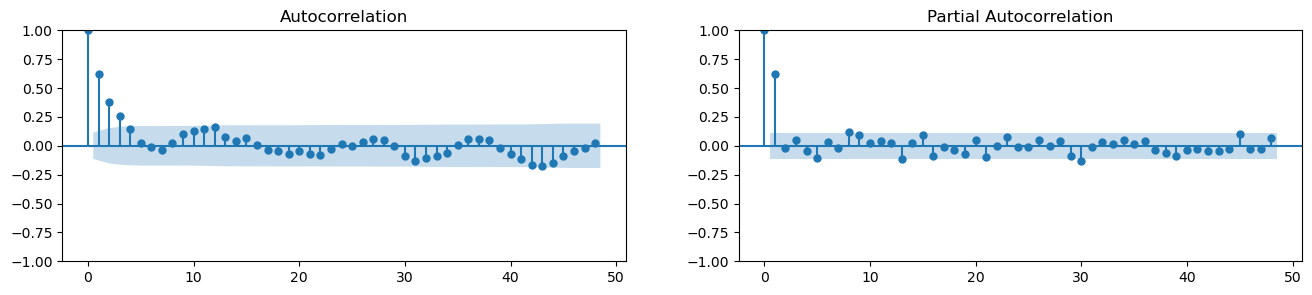

In [16]:
# Verifica os correlogramas
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(ipca, lags = 48, ax=axes[0]);
plot_pacf(ipca, lags = 48, ax=axes[1]);

# 4. Modelo

## 4.1 Modelo AR(1) com toda a amostra

In [17]:
# Modelo AR1
modelo1 = ARIMA(ipca, order = (1,0,0))

resultados1 = modelo1.fit()

print(resultados1.summary())

                               SARIMAX Results                                
Dep. Variable:                   ipca   No. Observations:                  292
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -74.168
Date:                Wed, 15 May 2024   AIC                            154.336
Time:                        12:54:41   BIC                            165.366
Sample:                    01-31-2000   HQIC                           158.754
                         - 04-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5048      0.053      9.467      0.000       0.400       0.609
ar.L1          0.6197      0.041     15.144      0.000       0.540       0.700
sigma2         0.0971      0.004     23.278      0.0

In [18]:
# Intervalos de Confiança
resultados1.conf_int()

,0,1
const,0.400297,0.609310
ar.L1,0.539519,0.699929
sigma2,0.088963,0.105321


In [19]:
# Parâmetros
resultados1.params

const     0.504803
ar.L1     0.619724
sigma2    0.097142
dtype: float64

## 4.2 Modelo AR(1) em janelas deslizantes

In [20]:
def fit_arima_rolling_window(data, window_size, order):
    """
    Ajusta um modelo ARIMA usando uma janela móvel.

    :param data: Série temporal a ser modelada.
    :param window_size: Tamanho da janela móvel.
    :param order: Ordem do modelo ARIMA.
    :return: Coeficientes do modelo ARIMA para cada janela.
    """
    # Inicializa lista para armazenar coeficientes
    coefs = []
    confint_df = []

    # Loop através dos dados, ajustando um modelo ARIMA para cada janela móvel
    for i in range(len(data) - window_size):
        window = data[i:i+window_size]

        # Ajusta modelo ARIMA
        model = ARIMA(window, order = order).fit()

        # Armazena coeficientes
        coefs.append(model.params)

        # Armazena os intervalos de confiança em um df
        confint = model.conf_int()
        confint_df.append(confint)

    # Cria df para os coeficientes
    coefs_df = pd.DataFrame(np.array(coefs),
                     columns = ['const', 'ar', 'sigma']
                    )

    confint_df = pd.concat(confint_df)

    # Filtra apenas o componente AR nos intervalos
    confint_df = confint_df.filter(like = 'ar', axis = 0)
    # Retira o índice com o nome do componente
    confint_df.reset_index(inplace = True, drop = True)

    # Junta os dois dfs e renomeia as colunas dos intervalos de confiança
    ar_rolling = coefs_df.join(confint_df).rename(columns = {0 : 'lower', 1 : 'upper'})
    ar_rolling.index = data.iloc[window_size:].index

    return ar_rolling

In [21]:
ar1 = fit_arima_rolling_window(ipca, window_size = 48, order = (1,0,0))

c:\Users\pedro\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\pedro\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


In [22]:
ar1

,const,ar,sigma,lower,upper
Date,,,,,
2004-01,0.701554,0.618213,0.220276,0.339257,0.897170
2004-02,0.695870,0.625405,0.219259,0.346146,0.904663
2004-03,0.703901,0.617411,0.218132,0.338314,0.896507
2004-04,0.710965,0.613189,0.216821,0.336215,0.890164
2004-05,0.692968,0.622243,0.217038,0.345294,0.899193
...,...,...,...,...,...
2023-12,0.528250,0.575495,0.154389,0.326374,0.824616
2024-01,0.498470,0.594842,0.141177,0.355986,0.833697
2024-02,0.499862,0.590978,0.141058,0.352585,0.829372


In [23]:
# Altera o tipo do índice para datetime
ar1.index = ar1.index.to_timestamp()

# Retira do índice
ar1.reset_index(inplace = True)

In [25]:
ar1

,Date,const,ar,sigma,lower,upper
0,2004-01-01,0.701554,0.618213,0.220276,0.339257,0.897170
1,2004-02-01,0.695870,0.625405,0.219259,0.346146,0.904663
2,2004-03-01,0.703901,0.617411,0.218132,0.338314,0.896507
3,2004-04-01,0.710965,0.613189,0.216821,0.336215,0.890164
4,2004-05-01,0.692968,0.622243,0.217038,0.345294,0.899193
...,...,...,...,...,...,...
239,2023-12-01,0.528250,0.575495,0.154389,0.326374,0.824616
240,2024-01-01,0.498470,0.594842,0.141177,0.355986,0.833697
241,2024-02-01,0.499862,0.590978,0.141058,0.352585,0.829372
242,2024-03-01,0.517847,0.587288,0.143983,0.344252,0.830323


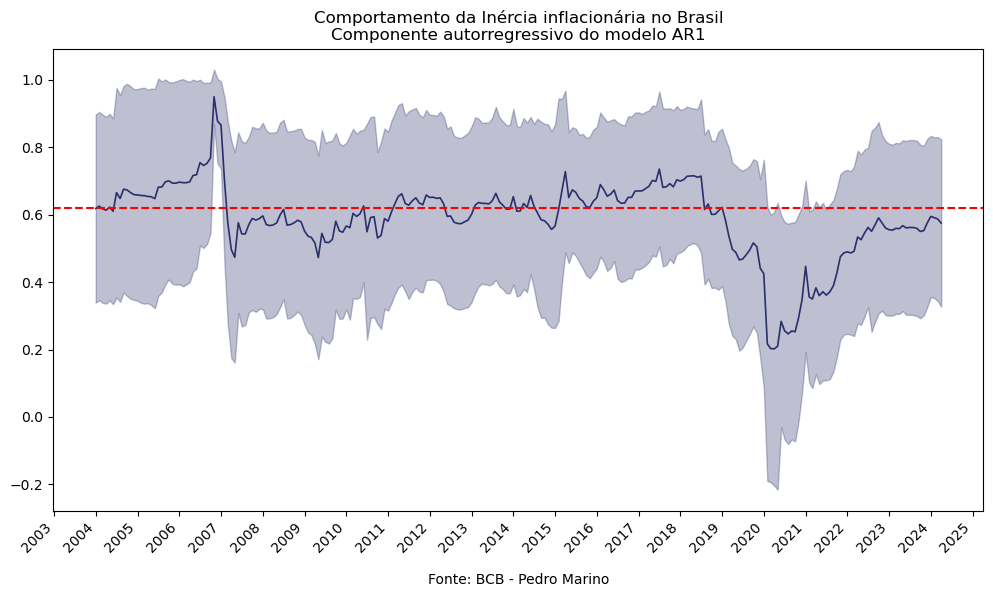

In [28]:
# Criando a figura e os eixos
fig, ax = plt.subplots(figsize = (12,6))

# Adicionando a faixa
ax.fill_between(ar1['Date'], ar1['lower'], ar1['upper'], color='#282f6b', alpha=0.3)

# Adicionando a linha
ax.plot(ar1['Date'], ar1['ar'], color='#282f6b', linewidth=1.2)

# Adicionando a linha horizontal
ax.axhline(y=resultados1.params['ar.L1'], color='red', linestyle='--')

# Configurando o eixo x para mostrar anos
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y"))
ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# Adicionando rótulos e título
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Comportamento da Inércia inflacionária no Brasil\nComponente autorregressivo do modelo AR1')
ax.text(0.5, -0.15, 'Fonte: BCB - Pedro Marino', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Rotacionando os rótulos do eixo x
plt.xticks(rotation=45, ha='right')

# Mostrando o gráfico
plt.show()